# FF parameterization and MD export w/ OpenFF
Minimal example of how to take a molecular structure defined by RDKit and turn them into MD-ready input files  
RDKit Mol input here is presumed to be generated by a MuPT builder, though nothing about the way this example is set up forces that to be the case

In [1]:
from rdkit import Chem
from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange

## Load previously-built molecule (presumed exported from MuPT)

1140


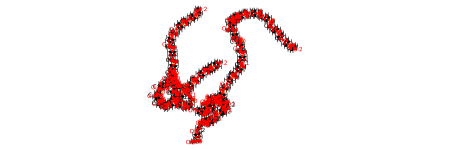

In [2]:
from pathlib import Path

struct_file_name : str = 'ellipsoidal_backmap_4x[10-15]-mer_chains.sdf'
# struct_file_name : str = 'ellipsoidal_backmap_10x[15-25]-mer_chains.sdf'
struct_file_path : Path = Path(f'mupt-built_systems/{struct_file_name}')


with Chem.SDMolSupplier(str(struct_file_path), removeHs=False) as suppl:
    mol = next(suppl)
# mol = Chem.MolFromMolFile(str(struct_file_path), removeHs=False)
Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_CLEANUP)
print(mol.GetNumAtoms())
display(mol)

## Convert RDKit mols to OpenFF Molecules, parameterize, and bundle into Interchange

In [3]:
from rich.progress import track
import logging
# logging.basicConfig(level=logging.DEBUG, force=True)

from functools import reduce


ff = ForceField('openff-2.2.1.offxml')

mol_incs : list[Interchange] = []
mols = Chem.GetMolFrags(mol, asMols=True)
for chain in track(mols, description='Adding molecules to OpenFF Topology', auto_refresh=False):
    offmol = Molecule.from_rdkit(chain, allow_undefined_stereo=True, hydrogens_are_explicit=True)
    offmol.assign_partial_charges(partial_charge_method='openff-gnn-am1bcc-1.0.0.pt') # partial_charge_method='gasteiger')
    mol_incs.append(
        ff.create_interchange(offmol.to_topology(), charge_from_molecules=[offmol])
    )

logging.warning('Combining Interchanges per-molecule into master Interchange')
inc : Interchange = reduce(Interchange.combine, mol_incs) # NOTE: found significantly faster to parameterize individually and combine, rather than parameterizing the full system at once
logging.warning('Successfully created Interchange for entire chemical system')

Output()

/home/timber/miniconda3/envs/mupt-dev/lib/python3.13/site-packages/openff/interchange/operations/_combine.py:104: InterchangeCombinationWarning: Interchange object combination is complex and may produce strange results outside of use cases it has been tested in. Use with caution and thoroughly validate results!
  warnings.warn(


### Size and assign smallest periodic box which contains system


In [4]:
import numpy as np
from openff.units import unit


exclusion : float = 0.0*unit.nanometer

box_lengths = np.ptp(inc.topology.get_positions(), axis=0)
box_vectors = np.diag( (box_lengths + 2*exclusion).m_as('nanometer') ) * unit.nanometer
inc.box = box_vectors

## Write MD outputs

In [5]:
offdir : Path = Path('OpenFF_MD_input_files')
offdir.mkdir(exist_ok=True)
system_name : str = 'amorphous_melt'

### LAMMPS

In [6]:
lmpdir = offdir / 'LAMMPS'
lmpdir.mkdir(exist_ok=True)
inc.to_lammps(prefix=str(lmpdir / system_name), include_type_labels=False)

/home/timber/miniconda3/envs/mupt-dev/lib/python3.13/site-packages/openff/interchange/components/mdconfig.py:295: SwitchingFunctionNotImplementedWarning: A switching distance 8.0 angstrom was specified by the force field, but LAMMPS may not implement a switching function as specified by SMIRNOFF. Using a hard cut-off instead. Non-bonded interactions will be affected.
  warnings.warn(


### GROMACS

In [7]:
# Skipping for now, as export is too slow to be practical even for modestly-large systems
# gmxdir = offdir / 'GROMACS'
# gmxdir.mkdir(exist_ok=True)
# inc.to_gromacs(prefix=str(gmxdir / system_name))

### OpenMM (NPT simulation, w/ both thermostat and barostat action)

In [8]:
from openmm.unit import Quantity, kelvin, atmosphere, femtosecond, picosecond, nanosecond


temperature : Quantity = 300.0*kelvin
pressure : Quantity = 1.0*atmosphere

sim_time_total : Quantity = 10*picosecond #1*nanosecond
# sim_time_total : Quantity = 40*picosecond
time_step : Quantity = 1.0*femtosecond
n_samples : int = 100

In [9]:
from openmm import LangevinMiddleIntegrator, MonteCarloBarostat


n_steps : int = round(sim_time_total / time_step)
integrator = LangevinMiddleIntegrator(temperature, 1.0*picosecond**-1, time_step)
barostat = MonteCarloBarostat(pressure, temperature, 25)

sim = inc.to_openmm_simulation(
    integrator=integrator,
    combine_nonbonded_forces=False,
    additional_forces=[barostat],
)
sim.minimizeEnergy() # minimize before saving initial system snapshot (also check that minimization doesn't crash)
state = sim.context.getState(positions=True)

1 warning generated.


In [10]:
from openmm import XmlSerializer
from openmm.app import PDBFile


ommdir = offdir / 'OpenMM'
ommdir.mkdir(exist_ok=True)

# topology
top_path : Path = ommdir / f'{system_name}_topology.pdb'
with top_path.open('w') as top_file:
    PDBFile.writeFile(sim.topology, state.getPositions(asNumpy=True), top_file)
    
# system
sys_path : Path = ommdir / f'{system_name}_system.xml'
with sys_path.open('w') as sys_file:
    sys_file.write(XmlSerializer.serialize(sim.system))
    
# state
state_path : Path = ommdir / f'{system_name}_state.xml'
with state_path.open('w') as state_file:
    state_file.write(XmlSerializer.serialize(state))
    
# integrator
integ_path : Path = ommdir / f'{system_name}_integrator.xml'
with integ_path.open('w') as int_file:
    int_file.write(XmlSerializer.serialize(integrator))

#### Verify that serialized OpenMM inputs can be loaded back and used to setup a simulation

In [11]:
from openmm.app import Simulation, PDBFile

ommsim = Simulation(
    topology=PDBFile(str(top_path)).topology,
    system=str(sys_path),
    integrator=str(integ_path),
    state=str(state_path),
)

## Test system minimizes (and doesn't explode) for short OpenMM simulation

In [12]:
# NBVAL_SKIP
from openmm.app import DCDReporter, StateDataReporter

report_interval : int = round(n_steps / n_samples)

traj_path : Path = ommdir / f'{system_name}_trajectory.dcd'
traj_reporter = DCDReporter(str(traj_path), reportInterval=report_interval)
ommsim.reporters.append(traj_reporter)

state_data_path : Path = ommdir / f'{system_name}_state_data.csv'
state_params : dict[str, bool] = {
    'step' : False,
    'time' : True,
    'potentialEnergy' : True,
    'kineticEnergy' : True,
    'totalEnergy' : False,
    'temperature' : True,
    'volume' : True,
    'density' : True,
    'progress' : False,
    'remainingTime' : False,
    'speed' : True,
    'elapsedTime' : False,
}
statedat_reporter = StateDataReporter(
    str(state_data_path),
    reportInterval=report_interval,
    **state_params
)
ommsim.reporters.append(statedat_reporter)

ommsim.step(n_steps) # call to integrate simulation